In [1]:
# %load ../../../load_magic/storage.py

!mkdir ../../data
!mkdir ../../data/csv
!mkdir ../../saves
!mkdir ../../saves/pickle
!mkdir ../../saves/csv
import pickle
import pandas as pd
import os

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

# Change this to your data and saves folders
data_folder = r'../../data/'
saves_folder = r'../../saves/'

def load_csv(csv_name=None):
    csv_folder = data_folder + 'csv/'
    if csv_name is None:
        csv_path = max([os.path.join(csv_folder, f) for f in os.listdir(csv_folder)],
                       key=os.path.getmtime)
    else:
        csv_path = csv_folder + csv_name + '.csv'
    data_frame = pd.read_csv(csv_path, encoding=encoding)
    
    return(data_frame)

def load_object(obj_name):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

def save_dataframes(include_index=False, **kwargs):
    csv_folder = saves_folder + 'csv/'
    for frame_name in kwargs:
        if isinstance(kwargs[frame_name], pd.DataFrame):
            csv_path = csv_folder + frame_name + '.csv'
            kwargs[frame_name].to_csv(csv_path, sep=',', encoding=encoding,
                                      index=include_index)

# Classes, functions, and methods cannot be pickled
def store_objects(**kwargs):
    for obj_name in kwargs:
        if hasattr(kwargs[obj_name], '__call__'):
            raise RuntimeError('Functions cannot be pickled.')
        obj_path = saves_folder + 'pickle/' + str(obj_name)
        pickle_path = obj_path + '.pickle'
        if isinstance(kwargs[obj_name], pd.DataFrame):
            kwargs[obj_name].to_pickle(pickle_path)
        else:
            with open(pickle_path, 'wb') as handle:
                pickle.dump(kwargs[obj_name], handle, pickle.HIGHEST_PROTOCOL)

mkdir: ../../data: File exists
mkdir: ../../data/csv: File exists
mkdir: ../../saves: File exists
mkdir: ../../saves/pickle: File exists
mkdir: ../../saves/csv: File exists


In [2]:

from sklearn.decomposition import PCA
import os

obj_path = saves_folder + 'pickle/gapminder_df.pickle'
if not os.path.isfile(obj_path):
    gapminder_df = pd.read_csv(data_folder + 'csv/gapminder.csv', low_memory=False, encoding=encoding)
else:
    gapminder_df = load_object('gapminder_df')
gapminder_df.columns = ['country_name', 'income_per_person', 'alcohol_consumption', 'armed_forces_rate', 'breast_cancer_per_100th', 
                        'co2_emissions', 'female_employment_rate', 'hiv_rate', 'internet_use_rate', 'life_expectancy', 'oil_per_person', 
                        'polity_score', 'residential_electricity_per_person', 'suicide_per_100th', 'employment_rate', 'urban_rate']
number_column_list = list(set(gapminder_df.columns) - set(['country_name']))
elite_df = gapminder_df.dropna(how='any').copy()
elite_ndarray = PCA(n_components=2).fit_transform(elite_df[number_column_list])

Silhouette Coefficient: 0.679


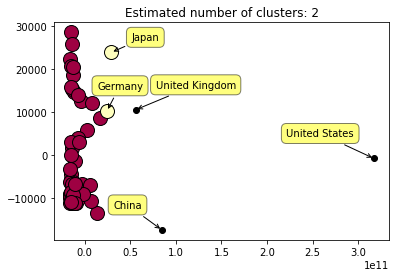

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=7750000000, min_samples=2).fit(elite_ndarray)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(elite_ndarray, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    
    # Black used for noise
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = elite_ndarray[class_member_mask & core_samples_mask]
    line_2d = plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = elite_ndarray[class_member_mask & ~core_samples_mask]
    line_2d = plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

text = plt.title('Estimated number of clusters: %d' % n_clusters_)
for col, label, x, y in zip(labels, elite_df['country_name'], elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10), textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20), textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20), textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

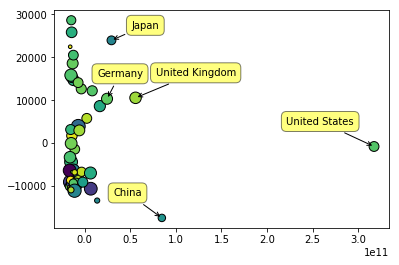

In [176]:

cmap = plt.get_cmap('viridis_r')
path_collection = plt.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1], s=elite_df['alcohol_consumption']*10, c=elite_df['suicide_per_100th'],
                              edgecolors=(0, 0, 0), cmap=cmap)
for col, label, x, y in zip(labels, elite_df['country_name'], elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10), textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20), textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20), textcoords='offset points', ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

In [139]:

def create_binned_categories(df, number_of_categories, column_name, prefix):
    out_categorical, percentiles_list = pd.cut([0, 1], number_of_categories, retbins=True)
    describe_series = df[column_name].describe(percentiles=percentiles_list[1:-1]).copy()
    bad_list = ['count', 'mean', 'std']
    if (number_of_categories % 2) == 1:
        bad_list += ['50%']
    index_list = [x for x in describe_series.index.tolist() if x not in bad_list]
    bin_list = describe_series.loc[index_list].tolist()
    group_names = [x for x in range(1, len(bin_list))]
    category_series = pd.cut(df[column_name], bin_list, labels=group_names)
    df[prefix+'_categories'] = pd.cut(df[column_name], bin_list, labels=group_names)
    df[prefix+'_binned'] = pd.cut(df[column_name], bin_list)
    
    # Fix the bottom row
    null_series = df[prefix+'_categories'].isnull()
    bottom_series = (df[prefix+'_categories'] == 1)
    binned_value = df[bottom_series][prefix+'_binned'].min()
    df.loc[null_series, prefix+'_categories'] = 1
    df.loc[null_series, prefix+'_binned'] = binned_value

    return df

In [150]:

number_of_categories = 2
elite_df = create_binned_categories(elite_df, number_of_categories, 'income_per_person', prefix='ipp')
column_list = ['country_name', 'income_per_person', 'ipp_categories', 'ipp_binned']
elite_df[column_list].sort_values('ipp_categories').head()
pd.value_counts(elite_df['ipp_categories'])

,country_name,income_per_person,ipp_categories,ipp_binned
5,Algeria,2231.993335,1,"(558.063, 6219.693]"
111,Indonesia,1143.831514,1,"(558.063, 6219.693]"
112,Iran,2161.546510,1,"(558.063, 6219.693]"
124,Kazakhstan,2481.718918,1,"(558.063, 6219.693]"
141,Lithuania,5332.238591,1,"(558.063, 6219.693]"


2    28
1    28
Name: ipp_categories, dtype: int64

In [163]:

from IPython.display import HTML
import statsmodels.formula.api as smf

def bi_categorical_anova_interpretation(df, ce_column_name, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name):
    column_list = [ce_column_name, qr_column_name]
    all_countries_df = df[column_list].dropna().copy()

    all_sd_df = all_countries_df.groupby(ce_column_name).std()
    all_mean_df = all_countries_df.groupby(ce_column_name).mean()

    # Use ols function for calculating the F-statistic and associated p value
    all_ols = smf.ols(formula=qr_column_name+' ~ C('+ce_column_name+')', data=all_countries_df)
    all_fitted = all_ols.fit()
    
    # Figure out the adverbs
    f_pvalue = all_fitted.f_pvalue
    if f_pvalue <= 0.05:
        adverb_significant = 'a significantly'
    else:
        adverb_significant = 'an insignificantly'
    low_mean = all_mean_df.loc[0, qr_column_name]
    high_mean = all_mean_df.loc[1, qr_column_name]
    if high_mean > low_mean:
        adverb_higher = 'higher'
    else:
        adverb_higher = 'lower'

    return ('<h3>Model Interpretation for ANOVA:</h3><p>When examining the association between ' +
            qr_formal_name + ' (quantitative response) and ' +
            ce_formal_name + ' (2 categories, which is the categorical explanatory variable), an Analysis of Variance (ANOVA) revealed that those countries with a higher ' +
            ce_informal_name + ' reported ' +
            adverb_significant + ' ' +
            adverb_higher + ' ' +
            qr_informal_name + ' (Mean=' +
            str('%.1f' % high_mean) + ', s.d. ±' +
            str('%.1f' % all_sd_df.loc[1, qr_column_name]) + ') compared to those with a lower ' +
            ce_informal_name + ' (Mean=' +
            str('%.1f' % low_mean) + ', s.d. ±' +
            str('%.1f' % all_sd_df.loc[0, qr_column_name]) + '), F(' +
            str('%d' % all_fitted.df_model) + ', ' +
            str('%d' % all_fitted.df_resid) + ')=' +
            str('%.2f' % all_fitted.fvalue) + ', p=' +
            str('%.3f' % f_pvalue) + '.</p>')

In [164]:

ce_column_name = 'ipp_categories'
qr_column_name = 'suicide_per_100th'
ce_formal_name = '2010 Gross Domestic Product per capita in constant 2000 US$'
qr_formal_name = '2005 Suicide, age adjusted, per 100,000'
ce_informal_name = 'income per person'
qr_informal_name = 'suicide rate'
HTML(bi_categorical_anova_interpretation(elite_df, ce_column_name, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name))

In [165]:

number_of_categories = 5
elite_df = create_binned_categories(elite_df, number_of_categories, 'income_per_person', prefix='ipp')
column_list = ['country_name', 'income_per_person', 'ipp_categories', 'ipp_binned']
elite_df[column_list].sort_values('ipp_categories').sample(5)
pd.value_counts(elite_df['ipp_categories'])

,country_name,income_per_person,ipp_categories,ipp_binned
236,Spain,15461.758372,4,"(11744.834, 26692.984]"
33,Bulgaria,2549.558474,2,"(2344.897, 4699.411]"
186,Pakistan,668.547943,1,"(558.063, 2344.897]"
117,Italy,18982.269285,4,"(11744.834, 26692.984]"
249,Thailand,2712.517199,2,"(2344.897, 4699.411]"


1    12
5    11
4    11
3    11
2    11
Name: ipp_categories, dtype: int64

In [172]:

from IPython.display import HTML
import statsmodels.stats.multicomp as multi
import io

def multi_categorical_anova_interpretation(df, ce_column_name, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name):
    column_list = [ce_column_name, qr_column_name]
    all_countries_df = df[column_list].dropna().copy()

    all_sd_df = all_countries_df.groupby(ce_column_name).std()
    all_mean_df = all_countries_df.groupby(ce_column_name).mean()
    
    # Multiple Comparison of Means - Tukey HSD
    elite_mc = multi.MultiComparison(df[qr_column_name], df[ce_column_name])
    elite_tukeyhsd = elite_mc.tukeyhsd()
    output = io.StringIO(initial_value=elite_tukeyhsd._results_table.as_csv().strip())
    elite_tukeyhsd_df = pd.read_csv(output).reset_index()
    output.close()
    elite_tukeyhsd_df.columns = elite_tukeyhsd_df.iloc[0]
    elite_tukeyhsd_df = elite_tukeyhsd_df.reindex(elite_tukeyhsd_df.index.drop(0))
    elite_tukeyhsd_df['reject'] = elite_tukeyhsd_df['reject'].map(lambda x: x.strip() == 'True')
    elite_tukeyhsd_df['group1'] = elite_tukeyhsd_df['group1'].map(lambda x: int(x.strip()))
    elite_tukeyhsd_df['group2'] = elite_tukeyhsd_df['group2'].map(lambda x: int(x.strip()))
    elite_tukeyhsd_df['meandiff'] = elite_tukeyhsd_df['meandiff'].map(lambda x: float(x.strip()))
    mask_series = (elite_tukeyhsd_df['reject'] == True)
    column_list = ['group1', 'group2', 'meandiff']
    ce_binned_column = ce_column_name.split('_')[0] + '_binned'
    number_of_categories = len(df[ce_column_name].unique())
    group_dict = dict(zip(range(1, number_of_categories+1),
                          [str(df.loc[(df[ce_column_name]==n),
                                      ce_binned_column].min()) for n in range(1, number_of_categories+1)]))
    
    def f(row):
        left_group = group_dict[row['group1']]
        right_group = group_dict[row['group2']]
        mean_diff = row['meandiff']
        if mean_diff > 0:
            adverb_higher = 'higher'
        else:
            adverb_higher = 'lower'

        return('the <code>' + 
               left_group + '</code> group reported significantly ' + 
               adverb_higher + ' ' + 
               ce_informal_name + ' compared to the <code>' + 
               right_group + '</code> group')
    
    # Use ols function for calculating the F-statistic and associated p value
    all_fitted = smf.ols(formula=qr_column_name+' ~ C('+ce_column_name+')', data=all_countries_df).fit()
    
    # Figure out the adverbs
    f_pvalue = all_fitted.f_pvalue
    
    if f_pvalue < 0.0001:
        f_pvalue_statement = ', p<0.0001'
    else:
        f_pvalue_statement = ', p=' + str('%.4f' % f_pvalue)
    
    if f_pvalue <= 0.05:
        adverb_significant = 'significantly'
    else:
        adverb_significant = 'insignificantly'
    
    group_series = elite_tukeyhsd_df[mask_series][column_list].apply(f, axis=1)
    if group_series.shape[0] > 0:
        group_revelation = ', and '.join(group_series) + '. All other comparisons were statistically similar.</p>'
    else:
        group_revelation = 'all comparisons were statistically similar.</p>'
    
    return ('<h3>Model Interpretation for post hoc ANOVA results:</h3><p>ANOVA revealed that ' +
            ce_formal_name + ' (' +
            str(number_of_categories) + ' categories, which is the categorical explanatory variable) and ' +
            qr_formal_name + ' (quantitative response variable) were ' +
            adverb_significant + ' associated, F(' +
            str('%d' % all_fitted.df_model) + ', ' +
            str('%d' % all_fitted.df_resid) + ')=' +
            str('%.2f' % all_fitted.fvalue) +
            f_pvalue_statement + '. Post hoc comparisons of ' +
            qr_informal_name + ' by pairs of ' +
            ce_informal_name + ' categories revealed that ' +
            group_revelation)

In [167]:

ce_column_name = 'ipp_categories'
qr_column_name = 'suicide_per_100th'
ce_formal_name = '2010 Gross Domestic Product per capita in constant 2000 US$'
qr_formal_name = '2005 Suicide, age adjusted, per 100,000'
ce_informal_name = 'income per person'
qr_informal_name = 'suicide rate'
HTML(multi_categorical_anova_interpretation(elite_df, ce_column_name, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name))

In [168]:

def display_anova_and_post_hoc_results(df, number_of_categories, category_column, category_prefix, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name):
    ce_column_name = category_prefix + '_categories'
    df = create_binned_categories(df, 2, category_column, category_prefix)
    anova_HTML = bi_categorical_anova_interpretation(df, ce_column_name, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name)
    df = create_binned_categories(df, number_of_categories, category_column, category_prefix)
    post_HTML = multi_categorical_anova_interpretation(df, ce_column_name, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name)
    
    return HTML(anova_HTML + post_HTML)

In [169]:

number_of_categories = 5
category_column = 'income_per_person'
category_prefix = 'ipp'
qr_column_name = 'suicide_per_100th'
ce_formal_name = '2010 Gross Domestic Product per capita in constant 2000 US$'
qr_formal_name = '2005 Suicide, age adjusted, per 100,000'
ce_informal_name = 'income per person'
qr_informal_name = 'suicide rate'
display_anova_and_post_hoc_results(elite_df, number_of_categories, category_column, category_prefix, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name)

In [173]:

number_of_categories = 5
category_column = 'alcohol_consumption'
category_prefix = 'ac'
qr_column_name = 'suicide_per_100th'
ce_formal_name = '2008 alcohol consumption per adult, litres'
qr_formal_name = '2005 Suicide, age adjusted, per 100,000'
ce_informal_name = 'alcohol consumption'
qr_informal_name = 'suicide rate'
display_anova_and_post_hoc_results(elite_df, number_of_categories, category_column,
                                   category_prefix, qr_column_name, ce_formal_name, qr_formal_name, ce_informal_name, qr_informal_name)